Cloning into 'course-v3'...
remote: Enumerating objects: 4044, done.
remote: Total 4044 (delta 0), reused 0 (delta 0), pack-reused 4044
Receiving objects: 100% (4044/4044), 203.00 MiB | 32.26 MiB/s, done.
Resolving deltas: 100% (2264/2264), done.


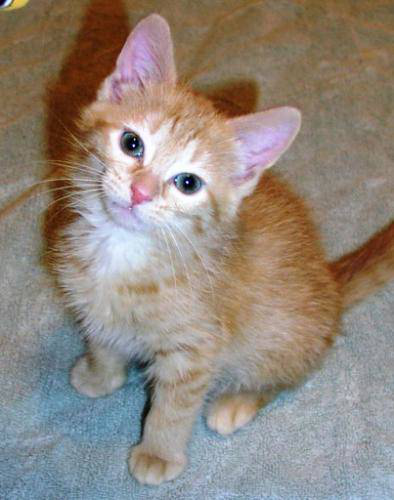

In [0]:
!git clone https://github.com/fastai/course-v3
from pathlib import Path
from PIL import Image

data_folder = Path("course-v3/nbs/dl1/images/notebook_tutorial/")

file_to_open = data_folder / "cat_example.jpg"

Image.open(file_to_open)

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

In [0]:
! pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.3)


In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abhinav2907","key":"580a41096dd47e678e0150da9c5615e1"}'}

In [0]:
! mkdir -p ~/.kaggle/

In [0]:
!cp kaggle.json ~/.kaggle/

In [0]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/planet')

In [0]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
! unzip -q -n {path}/train_v2.csv.zip -d {path}

 98% 588M/600M [00:05<00:00, 96.2MB/s]
100% 600M/600M [00:05<00:00, 118MB/s] 
  0% 0.00/159k [00:00<?, ?B/s]
100% 159k/159k [00:00<00:00, 61.7MB/s]


In [0]:
! pip install -y -c haasad eidl7zip


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -y


In [0]:
df = pd.read_csv(path/'train_v2.csv')
df.head()


,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [0]:
!sudo apt install p7zip-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.


In [0]:
! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}

In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [0]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [0]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

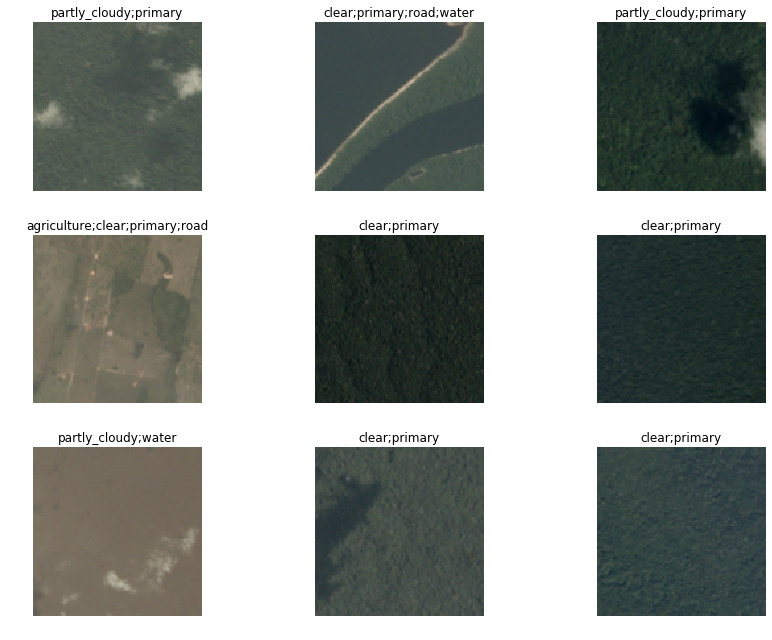

In [0]:
data.show_batch(rows=3, figsize=(12,9))

In [0]:
88+54

142

In [0]:
arch = models.resnet50

In [0]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


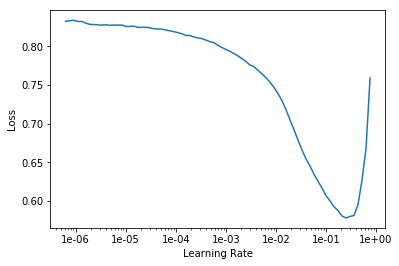

In [0]:
learn.recorder.plot()

In [0]:
lr = 0.01

In [0]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.125014,0.110399,0.941860,0.902389,03:48
1,0.109400,0.097009,0.951139,0.913784,03:50
2,0.102569,0.092175,0.954118,0.920527,03:52
3,0.095654,0.087616,0.955310,0.926118,03:49
4,0.092250,0.086996,0.957868,0.926265,03:44


In [0]:
learn.save('stage-1-rn50')

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


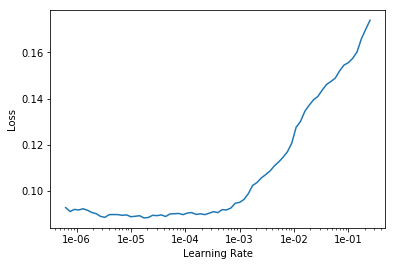

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.084777,0.087677,0.954322,0.923807,04:32
1,0.090610,0.086989,0.955477,0.922560,04:29
2,0.086473,0.084303,0.957483,0.926991,04:31
3,0.078228,0.083383,0.959278,0.927759,04:33
4,0.076153,0.083104,0.958522,0.928365,04:35


In [0]:
learn.save('stage-2-rn50')

In [42]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [0]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


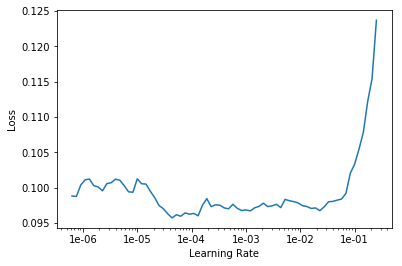

In [44]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr=1e-2/2

In [46]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.084291,0.085324,0.956037,0.926355,11:06
1,0.088266,0.084592,0.956495,0.926984,11:00
2,0.085380,0.082888,0.958239,0.928342,11:02
3,0.080823,0.082152,0.960346,0.928836,11:02
4,0.077994,0.081396,0.960382,0.931079,11:01


In [0]:
learn.save('stage-1-256-rn50')

In [0]:
learn.unfreeze()

In [49]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.083184,0.084771,0.957955,0.927879,14:30
1,0.084846,0.082969,0.958391,0.928280,14:24
2,0.080780,0.082307,0.957621,0.929073,14:26
3,0.076870,0.081355,0.959067,0.930739,14:29
4,0.073092,0.081062,0.958943,0.930904,14:32


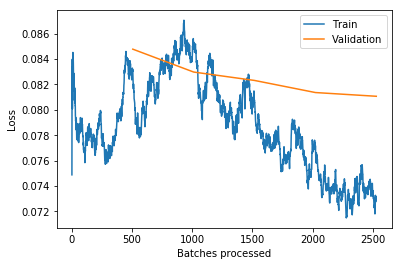

In [50]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage-2-256-rn50')

In [0]:
learn.export()

In [54]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  
! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path}  
! 7za -bd -y -so x {path}/test-jpg-additional.tar.7z | tar xf - -C {path}
test = ImageList.from_folder(path/'test-jpg').add(ImageList.from_folder(path/'test-jpg-additional'))
len(test)

 98% 594M/603M [00:06<00:00, 72.0MB/s]
100% 603M/603M [00:06<00:00, 94.5MB/s]
 96% 293M/304M [00:02<00:00, 131MB/s]
100% 304M/304M [00:02<00:00, 112MB/s]


61191

In [0]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [57]:
labelled_preds[:5]

['agriculture clear habitation primary road water',
 'agriculture clear cultivation primary road',
 'clear primary',
 'clear primary water',
 'agriculture clear cultivation primary']

In [0]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [0]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])

In [0]:
df.to_csv(path/'submission.csv', index=False)

In [61]:
! kaggle competitions submit planet-understanding-the-amazon-from-space -f {path/'submission.csv'} -m "My submission"

100% 2.20M/2.20M [00:00<00:00, 7.31MB/s]
Successfully submitted to Planet: Understanding the Amazon from Space